In [34]:
import numpy as np
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Layer
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

In [35]:
def plot_images(images, title, n_rows=10, n_cols=10):
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
    plt.suptitle(title, fontsize=16)
    for i, image in enumerate(images[:n_rows * n_cols]):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(image.reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_latent_space(compressed_data, labels):
    plt.figure(figsize=(8, 8))
    plt.scatter(compressed_data[:, 0], compressed_data[:, 1], c=labels, cmap='viridis', s=2)
    plt.colorbar()
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization')
    plt.show()

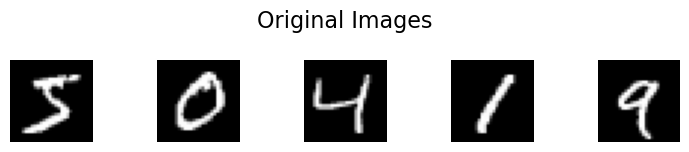

In [36]:
def load_mnist_data():
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
    return X_train

data = load_mnist_data()
plot_images(data, title='Original Images', n_rows=1, n_cols=5)


In [37]:
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [38]:
class VAELossLayer(Layer):
    def __init__(self, input_dim, **kwargs):
        self.input_dim = input_dim
        super(VAELossLayer, self).__init__(**kwargs)

    def vae_loss(self, inputs, outputs, z_mean, z_log_var):
        reconstruction_loss = tf.reduce_sum(tf.square(inputs - outputs), axis=-1)
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        return tf.reduce_mean(reconstruction_loss + kl_loss)

    def call(self, inputs):
        inputs, outputs, z_mean, z_log_var = inputs
        loss = self.vae_loss(inputs, outputs, z_mean, z_log_var)
        self.add_loss(loss)
        return outputs

In [39]:
def create_vae(input_dim, encoding_dim):
    # Encoder
    inputs = Input(shape=(input_dim,))
    h1 = Dense(128, activation='relu')(inputs)
    h2 = Dense(64, activation='relu')(h1)
    z_mean = Dense(encoding_dim)(h2)
    z_log_var = Dense(encoding_dim)(h2)

    z = Lambda(sampling, output_shape=(encoding_dim,))([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    latent_inputs = Input(shape=(encoding_dim,))
    h3 = Dense(64, activation='relu')(latent_inputs)
    h4 = Dense(128, activation='relu')(h3)
    outputs = Dense(input_dim, activation='sigmoid')(h4)

    decoder = Model(latent_inputs, outputs, name='decoder')

    # VAE
    outputs = decoder(encoder(inputs)[2])
    vae_loss_layer = VAELossLayer(input_dim)([inputs, outputs, encoder(inputs)[0], encoder(inputs)[1]])
    vae = Model(inputs, vae_loss_layer, name='vae')
    vae.compile(optimizer='adam')

    return vae, encoder, decoder

In [40]:
def train_vae(data, encoding_dim, epochs=50, batch_size=256):
    input_dim = data.shape[1]
    vae, encoder, decoder = create_vae(input_dim, encoding_dim)
    vae.fit(data, epochs=epochs, batch_size=batch_size, shuffle=True)
    return encoder, decoder, vae

encoder, decoder, vae = train_vae(data, encoding_dim=2)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 89.7974
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 48.2761
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 45.6541
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 44.0685
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 42.9546
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 42.1993
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 41.7580
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 41.2505
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 40.8805
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 40.5859
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 40.3133
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 39.9686
Epoch 13/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 39.7045
Epoch 14/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 39.4346
Epoch 15/50
235/235 ━━━━━━━━━

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


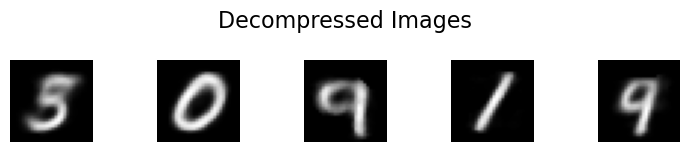

In [41]:

def compress(data, encoder):
    return encoder.predict(data)[0]

def decompress(compressed_data, decoder):
    return decoder.predict(compressed_data)

compressed_data = compress(data, encoder)
decompressed_data = decompress(compressed_data, decoder)
plot_images(decompressed_data, title='Decompressed Images', n_rows=1, n_cols=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


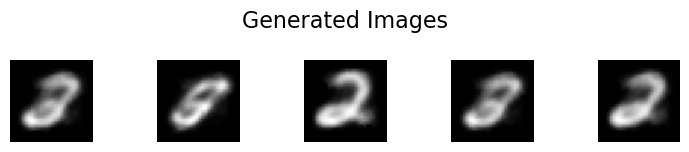

In [42]:
def generate_new_images(decoder, encoding_dim, n_images=10, noise_level=0.1):
    new_images = []
    for _ in range(n_images):
        random_encoded = np.random.normal(scale=noise_level, size=(1, encoding_dim))
        new_image = decoder.predict(random_encoded)
        new_images.append(new_image.reshape(28, 28))
    return np.array(new_images)

generated_images = generate_new_images(decoder, 2)
plot_images(generated_images, title='Generated Images', n_rows=1, n_cols=5)


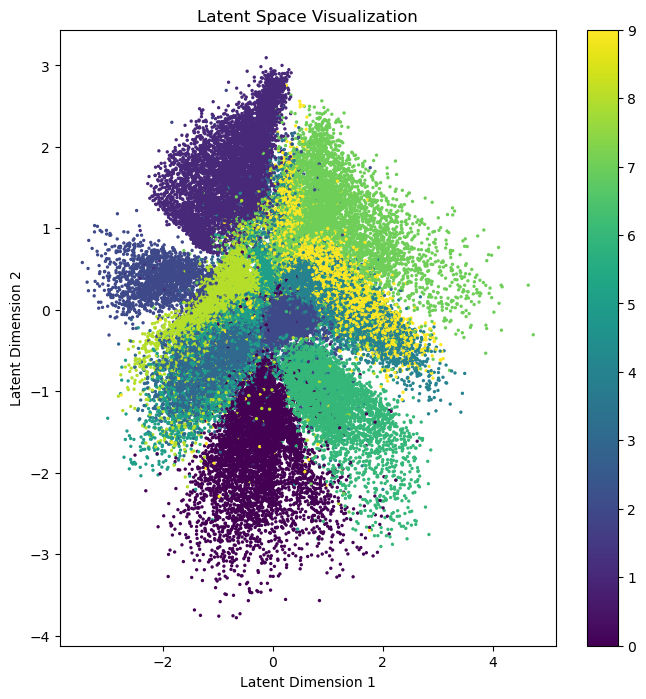

In [43]:
(X_train, y_train), (_, _) = mnist.load_data()
y_train = y_train[:compressed_data.shape[0]]
plot_latent_space(compressed_data, y_train)